## SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [2]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

In [30]:
def generate_trajectory(sigma_w_2, sigma_n_2, M, X_0):
    sigma_w = sigma_w_2 ** 0.5
    sigma_n = sigma_n_2 ** 0.5
    w = np.random.normal(0, sigma_w, M)
    n = np.random.normal(0, sigma_n, M)

    x = w.dot(np.tril(np.ones((M, M)))) + X_0 * np.ones(M)
    z = x + n
    return x, z

def generate_acc_trajectory(sigma_a_2, sigma_n_2, N, x_0, v_0, t, a_bias = 0):
    if sigma_a_2 == 0:
        a = np.zeros(N) + a_bias
    else:    
        a = np.random.normal(0, sigma_a_2 ** 0.5, N) + a_bias
    v = np.ones(N) * v_0 + a.dot(np.triu(np.ones((N, N)), 1)) * t
    x = np.ones(N) * x_0 + (v * t + a * t * t / 2).dot(np.triu(np.ones((N, N)), 1))
    z = x + np.random.normal(0, sigma_n_2 ** 0.5, N)
    return x, z, v

def calculate_exp_w_n(z):
    v = z - np.roll(z,1)
    p = z - np.roll(z,2)
    E_v = np.average((v ** 2)[1:])
    E_p = np.average((p ** 2)[2:])
    return E_p - E_v, E_v - E_p / 2

def alpha_opt(sigma_w_2, sigma_n_2):
    chi = sigma_w_2 / sigma_n_2
    return (-chi + (chi**2 + 4 * chi) ** 0.5) / 2

def M_opt(alpha):
    return int(round((2 - alpha) / alpha))

def running_mean(z, M, mask=None):
    if mask is None:
        mask = np.ones(M) / M
    m = int(M/2)
    z_ext = np.zeros(len(z) + 2 * m)
    z_ext[:m] = np.flip(z[:m], 0)
    z_ext[-m:] = np.flip(z[-m:], 0)
    z_ext[m:-m] = z
    return np.convolve(z_ext, mask, mode="same")[m:-m]

def exp_mean(z, alpha):
    exp_mean_z = z.copy()
    for i in range(1, len(z)):
        exp_mean_z[i] = exp_mean_z[i - 1] + alpha * (z[i] - exp_mean_z[i - 1])
    return exp_mean_z

def backward_exp_mean(x_f, alpha):
    x_b = x_f.copy()
    for i in range(len(x_b)-2,-1,-1):
        x_b[i] = x_b[i+1] + alpha*(x_f[i] - x_b[i+1])
    return x_b

# Smoothing procedure implies backward in time filtration

# Thus we need to add some code to Kalman filter

In [31]:
#T - transport matrix
#G - input
#z - measurements
#H - obs
#sigma_n - noise
#sigma_a - acc noise
#R = sigma_n**2 
#P_0 
def kalman(X_0, P_0, z, T, H, R, Q):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros_like(X) # ??? if z[i] not number
    T6 = np.linalg.matrix_power(T,6)
    for i, _ in enumerate(z):
        #Prediction
        X[i] = T.dot(X[i-1] if i > 0 else X_0)
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        #Filtration
        tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R)
        tmp2 = H.transpose().dot(tmp1)
        K[i] = P[i].dot(tmp2)
        X[i] = X[i] + K[i]*(z[i] - H.dot(X[i]))
        P[i] = (np.identity(X_0.shape[0]) - K[i].dot(H)).dot(P[i])
    return X,K,P
def backward_smoothing(X, P, Q, T):
    Xs = np.zeros_like(X)
    Pr = np.zeros_like(P)
    Ps = np.zeros_like(P)
    A = np.zeros_like(P)
    for i in range(N-1, -1, -1):
        Pr[i] = T.dot(P[i]).dot(T.transpose()) + Q
        A[i] = P[i].dot(T.transpose()).dot(inv(Pr[i]))
        Xs[i] = X[i] + A[i].dot((Xs[i+1] if i < N-1 else X[N-1]) - T.dot(X[i]))
        Ps[i] = P[i] + A[i].dot(Pr[i] - P[i]).dot(A[i].transpose())
    return Xs, A, Ps

In [32]:
N = 200
sigma_a = 0.2
q = 0.2
sigma_n = 20
x_1 = 5
v_1 = 1
t = 1
X_0 = np.array([[2],[0]])
P_0 = np.matrix([[10000, 0], [0,10000]])
G = np.array([[t**2/2], [t]])
H = np.array([[1, 0]])
Q = G.dot(G.transpose())*sigma_a**2
R = np.array([[sigma_n**2]])
T = np.matrix([[1, t],[0,1]])

In [54]:
x, z, v = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t)
X, K, P = kalman(X_0, P_0, z, T, H, R, Q)
Xs, A, Ps = backward_smoothing(X, P, Q, T)

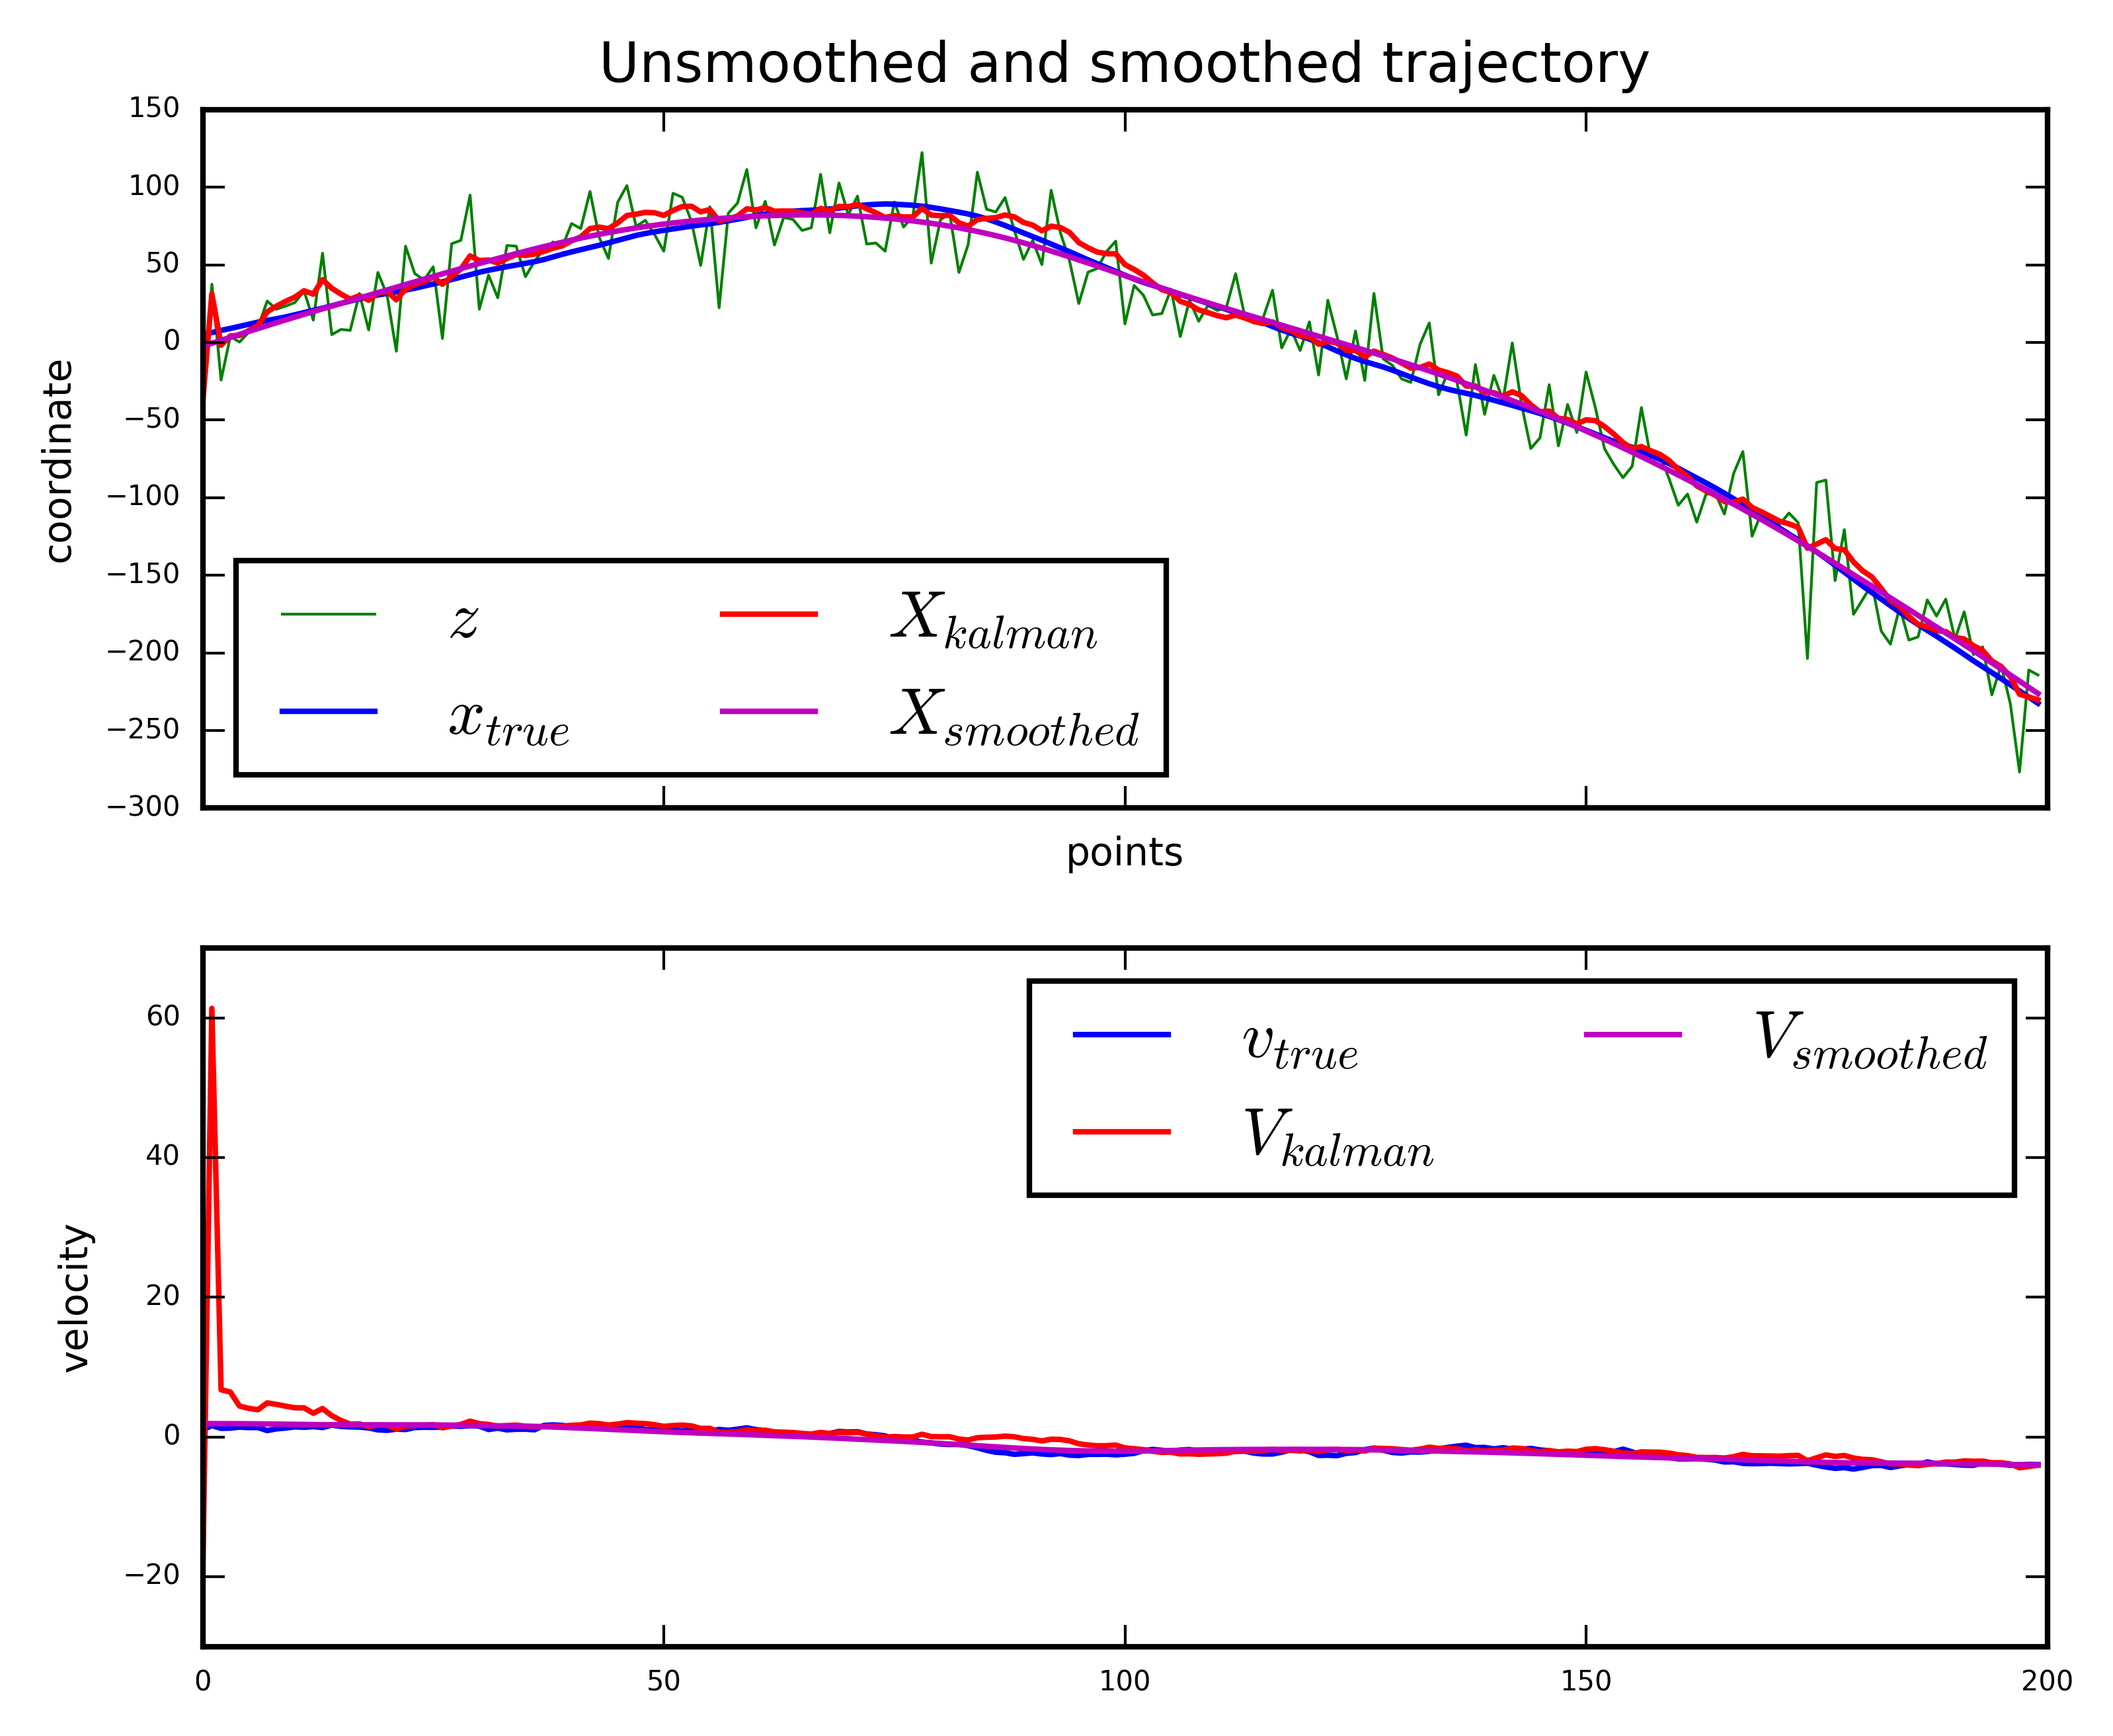

In [55]:
fig, ax = plt.subplots(2,1, figsize=(6,5), dpi=600, sharex=True)
ax[0].set_title('Unsmoothed and smoothed trajectory', fontsize = 10)
ax[0].plot(range(N),z,'g', label = '$z$', linewidth = 0.5 )
ax[0].plot(range(N),x,'b', label = '$x_{true}$', linewidth = 1 )
ax[0].plot(range(N),X[:,0].transpose()[0],'r', label = '$X_{kalman}$', linewidth = 1 )
ax[0].plot(range(N),Xs[:,0].transpose()[0],'m', label = '$X_{smoothed}$', linewidth = 1 )
#ax.plot(range(N),K[:,0].transpose()[0],'y', label = 'K', linewidth = 1 )
#ax.set_xlim([0,20])
ax[0].legend(loc='best', ncol=2)
ax[0].set_xlabel('points', fontsize = 7)
ax[0].set_ylabel('coordinate', fontsize = 7)
ax[1].plot(range(N),v,'b', label = '$v_{true}$', linewidth = 1 )
ax[1].plot(range(N),X[:,1].transpose()[0],'r', label = '$V_{kalman}$', linewidth = 1 )
ax[1].plot(range(N),Xs[:,1].transpose()[0],'m', label = '$V_{smoothed}$', linewidth = 1 )
#ax.plot(range(N),K[:,0].transpose()[0],'y', label = 'K', linewidth = 1 )
#ax.set_xlim([0,20])
ax[1].legend(loc='best', ncol=2)
ax[1].set_ylabel('velocity', fontsize = 7);

In [59]:
Repeats = 500
ErrorXTrue = np.zeros((N,Repeats))
ErrorVTrue = np.zeros((N,Repeats))
ErrorXSmoo = np.zeros((N,Repeats))
ErrorVSmoo = np.zeros((N,Repeats))
for i in range(0,Repeats):
    x, z, v = generate_acc_trajectory(sigma_a**2, sigma_n**2, N, x_1, v_1, t)
    X, K, P = kalman(X_0, P_0, z, T, H, R, Q)
    ErrorXTrue[:,i] = (x-X[:,0,0])**2
    ErrorVTrue[:,i] = (v-X[:,1,0])**2 
    Xs, A, Ps = backward_smoothing(X, P, Q, T)
    ErrorXSmoo[:,i] = (x-Xs[:,0,0])**2
    ErrorVSmoo[:,i] = (v-Xs[:,1,0])**2
    if i % 50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450


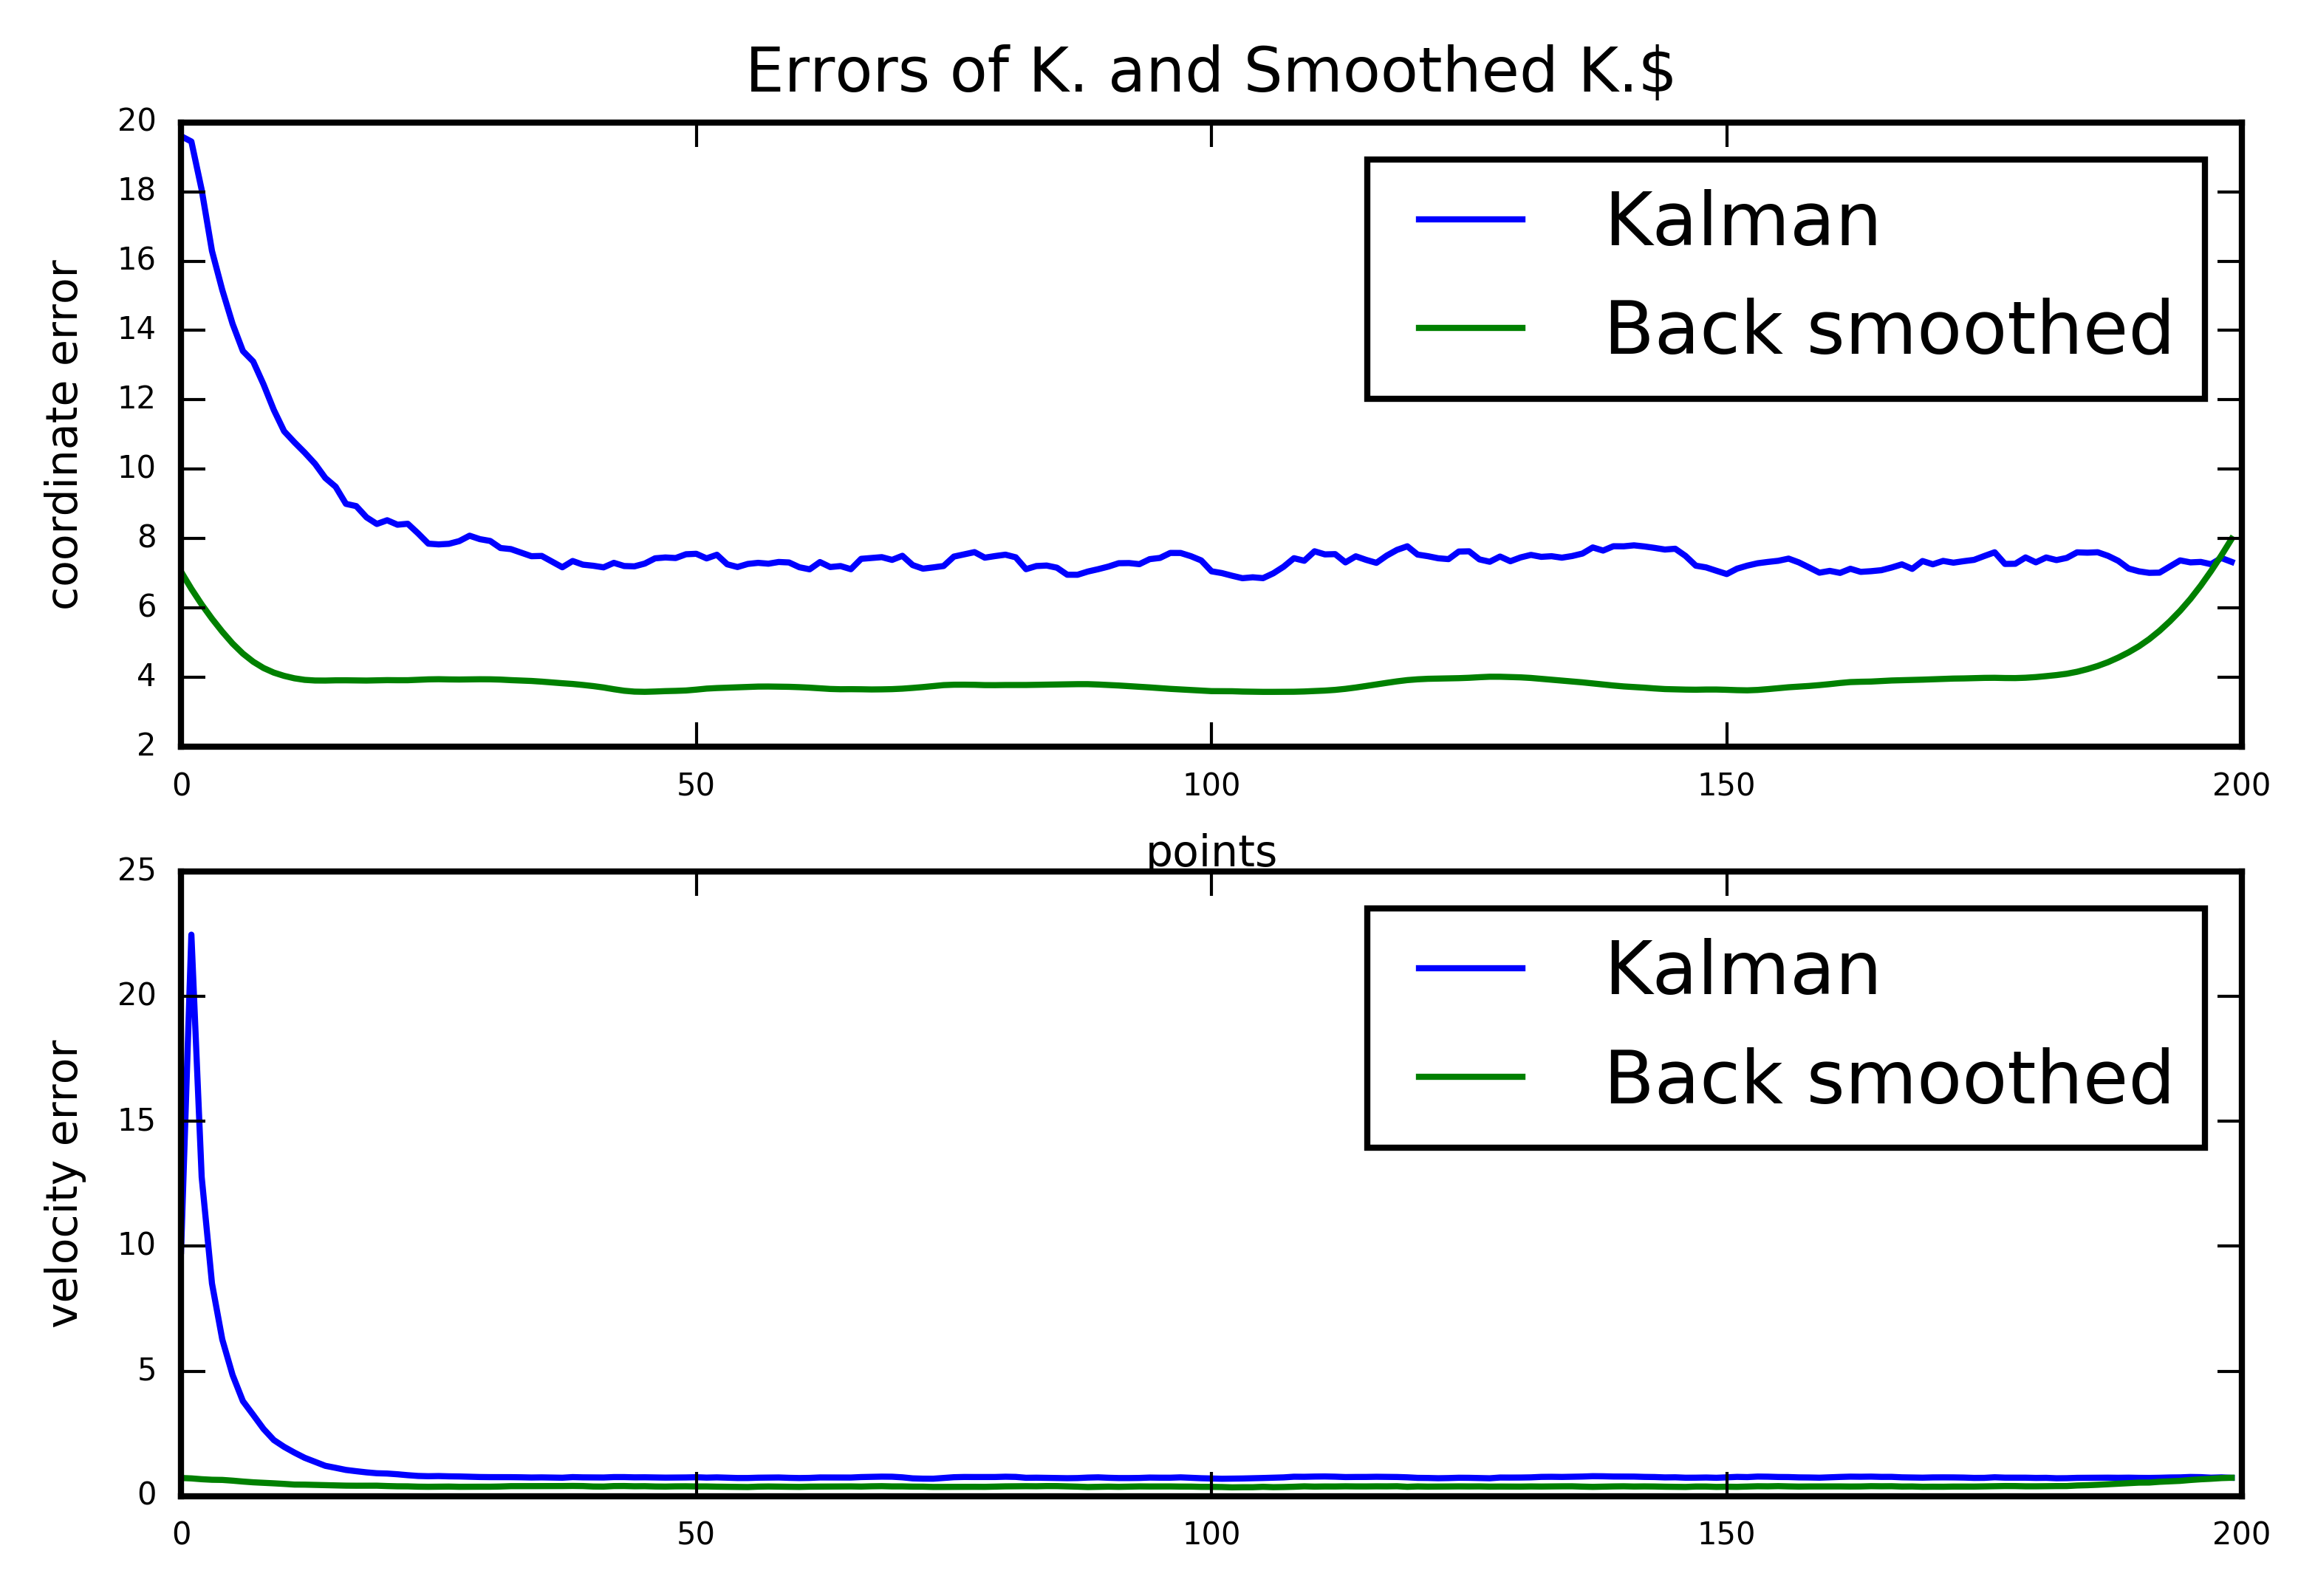

In [60]:
fig, ax = plt.subplots(2,1, figsize=(6,4), dpi = 600)
ax[0].set_title('Errors of K. and Smoothed K.$', fontsize = 10)
ax[0].plot( (np.sum(ErrorXTrue,axis=1)/(Repeats-1))**0.5, label = 'Kalman')
ax[0].plot(range(N),(np.sum(ErrorXSmoo,axis=1)/(Repeats-1))**0.5,  label = 'Back smoothed')
ax[0].legend(loc='best')
ax[0].set_xlabel('points', fontsize = 7)
ax[0].set_ylabel('coordinate error', fontsize = 7);

ax[1].plot( (np.sum(ErrorVTrue,axis=1)/(Repeats-1))**0.5, label = 'Kalman')
ax[1].plot(range(N),(np.sum(ErrorVSmoo,axis=1)/(Repeats-1))**0.5,  label = 'Back smoothed')
ax[1].legend(loc='best')
ax[1].set_ylabel('velocity error', fontsize = 7);

# As it can be seen from plots, smoothing performs best at the beginning, when Kalman filter wasn't tuned properly yet and worst at the ends (when initial estimate was picked from results of Kalman filter). And it's error is also times smaller on the whole trajectory.